In [63]:
# Add path with autoencoding code
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../code_autoencoding')

import numpy as np
from numpy import dot
from numpy.linalg import norm

import pandas as pd
import itertools
from itertools import combinations

import data_loader as dl
import autoencoder
import trainer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
# Helper functions for getting cosine similarity from drug response vectors.
def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

def combs_cos_sim(arr):

    if len(arr) < 2:
        #print(len(arr))
        return 1
    combs = list(combinations(np.arange(len(arr)), 2))
    sims = [cos_sim(arr[c[0]], arr[c[1]]) for c in combs]

    return np.mean(sims)

#### Read in both the data and meta data for LINCS level 2

In [78]:
data_path = "../data/shared_landmark_counts_vecs.gctx_n1269922x960.gctx"
lincs_data = dl.load_CMap(data_path)
lincs_data = lincs_data.iloc[:, 0:500000]
lincs_vectors = dict(dl.vectorize(lincs_data))

meta_data_path  = "../meta_data/GSE92742_Broad_LINCS_inst_info.txt"
meta_data = pd.read_csv(meta_data_path, sep = '\t')

<ipython-input-78-ff6c13dd56a1>:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_data = pd.read_csv(meta_data_path, sep = '\t')


#### Remove meta data for which there is no reponse in the LINCS data 

In [79]:
meta_data = meta_data[meta_data['inst_id'].isin(lincs_data.columns)]

#### Get the vector IDs (inst_id's) corresponding to each pertubation-cell combination

In [80]:
def get_pert_cell_combs(meta_df):
    
    pert_cell_combs = itertools.product(set(meta_df.cell_id), set(meta_df.pert_iname))
    pert_cell_combs = list(set(zip(meta_df.pert_iname, meta_df.cell_id)))
    
    vec_ids = dict()
    
    for c in pert_cell_combs:
        vec_ids[c] = meta_df.loc[(meta_df['pert_iname'] == c[0]) & (meta_df['cell_id'] == c[1])]['inst_id']
    
    return vec_ids

pert_cell_vector_dict = get_pert_cell_combs(meta_data)

#### Compute the mean vector for each pertubation-cell combination. This is the average response for a given cell type and drug in the native space.  Store the mean response to DMSO separately.

In [118]:
def get_mean_vec_from_control(all_vectors, vec_group_dict, cnt_condition = "DMSO"):
    
    group_mean_vectors = dict()
    cnt_mean_vectors = dict()

    for k, v in vec_group_dict.items():
        
        if (k[1] == 'MCF7') or (k[1] == 'A549') or (k[1] == 'A375') or (k[1] == 'VCAP'):
            group_vectors = [all_vectors[inst_id] for inst_id in v]
            group_mean_vectors[k] = np.mean(group_vectors, axis = 0)

            if(k[0] == cnt_condition):

                cnt_mean_vectors[k[1]] = np.mean(group_vectors, axis = 0)


                pca = PCA(n_components=2)
                pc_df = pd.DataFrame(data = pca.fit_transform(group_vectors), columns = ['PC1', 'PC2'])
                plt.scatter(pc_df.PC1, pc_df.PC2)
                plt.show()
    
    # Stubtract the mean control vector from everything for each group. 
    
    cnt_normed_mean_vectors = group_mean_vectors.copy()
    
    for k, v in group_mean_vectors.items():
        
        if k[1] == cnt_condition:
            cnt_normed_mean_vectors.pop(k)
        elif k[1] in cnt_mean_vectors:
            cnt_normed_mean_vectors[k] = v - cnt_mean_vectors[k[1]]
        else:
            cnt_normed_mean_vectors.pop(k)
    
    return cnt_normed_mean_vectors

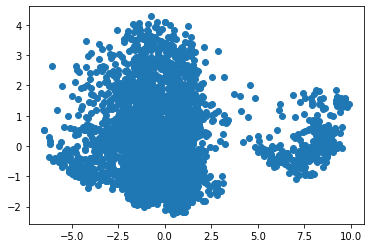

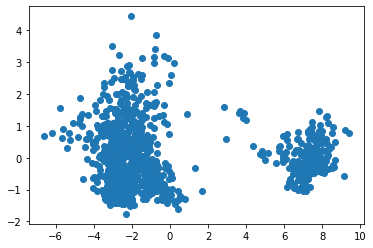

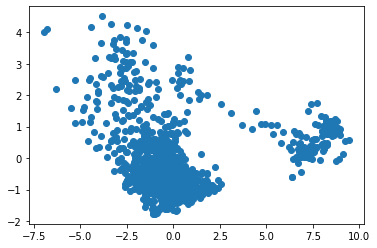

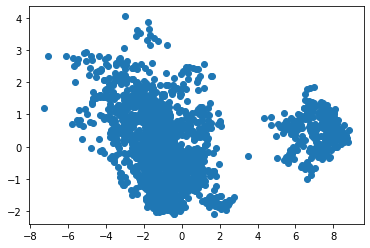

In [119]:
mean_vectors_native = get_mean_vec_from_control(lincs_vectors, pert_cell_vector_dict, cnt_condition = "DMSO")

#### For each perturbation, get the cosine similarity between the mean responses for each cell

In [120]:
def get_group_cos_sims(all_vectors, meta_df, grp_id = 'pert_iname', ind_id = 'cell_id'):
    
    # Remove any meta data entries tha don't have corresponding vectors
    grps, inds = (zip(*mean_vectors_native.keys()))
    meta_df =  meta_df.loc[(meta_df[grp_id].isin(grps)) & (meta_df[ind_id].isin(inds))]
    
    grp_cos_sims = dict()

    for grp in set(meta_df[grp_id]):

        keys = [(grp, ind) for ind in set(meta_df[meta_df[grp_id] == grp][ind_id])]

        grp_vectors = [all_vectors[(grp, ind)] for (grp, ind) in keys]

        grp_cos_sims[grp] = combs_cos_sim(grp_vectors)
    
    return grp_cos_sims

native_cos_sims = get_group_cos_sims(mean_vectors_native, meta_data, grp_id = 'pert_iname', ind_id = 'cell_id')

<ipython-input-4-a97f51e95e6b>:3: RuntimeWarning: invalid value encountered in float_scalars
  return dot(a, b)/(norm(a)*norm(b))


(array([5.000e+00, 1.000e+01, 2.950e+02, 1.764e+03, 2.022e+03, 1.127e+03,
        5.740e+02, 1.370e+02, 1.910e+02, 8.967e+03]),
 array([-0.62590724, -0.46331652, -0.30072579, -0.13813507,  0.02445565,
         0.18704638,  0.3496371 ,  0.51222783,  0.67481855,  0.83740928,
         1.        ]),
 <BarContainer object of 10 artists>)

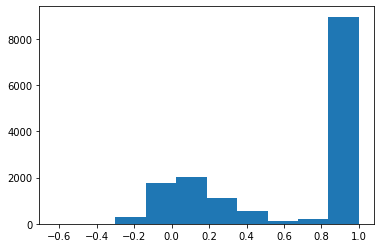

In [121]:
plt.hist(native_cos_sims.values())

In [122]:
def get_latent_rep(native_vectors, model_path):
    
    vectors_torch = dl.TorchVectors(list(native_vectors.items()))
    val_loader = DataLoader(vectors_torch, batch_size=1, pin_memory=True, shuffle=False)

    # Retrieve the architecture of the model
    params = torch.load(model_path)
    latent_size, input_size = params['state_dict']['net.0.weight'].shape
    weights_encode = torch.nn.Parameter(params['state_dict']['net.0.weight'])
    
    # Initialize the encoding layer, apply weights
    to_latent_nn = nn.Linear(input_size, latent_size, bias=False)
    to_latent_nn.weight = weights_encode
    to_latent_nn.eval()
    to_latent_nn.cuda()
    
    output = dict()

    for idx, batch in enumerate(val_loader):
        
        key, vals = batch[0][0], batch[1]
        inputs = Variable(vals).cuda()
        with torch.no_grad():
            output[key] = to_latent_nn(inputs)
    to_latent_nn.cpu()

    latent_vectors = dict()

    for key, vals in output.items():
        latent_vectors[key] = vals.cpu().numpy()[0]
    
    return latent_vectors

#### Now map to the latent space for a model before checking the improvement in alignment

In [97]:
latent_vectors = get_latent_rep(lincs_vectors, "../trained_model_parameters/5.93e-06_counts150epoch_leakyReLu_960_1024_model_best.pth")

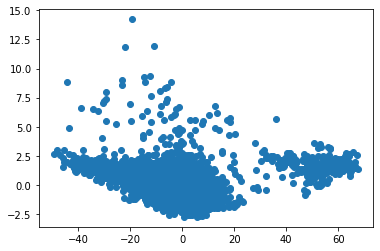

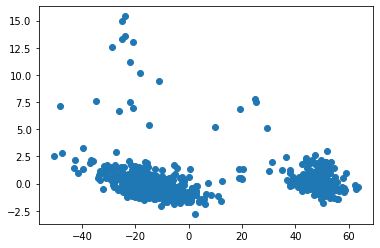

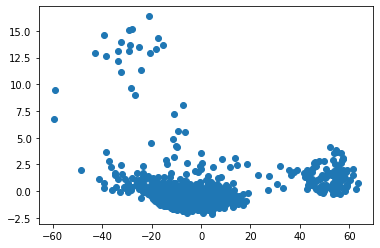

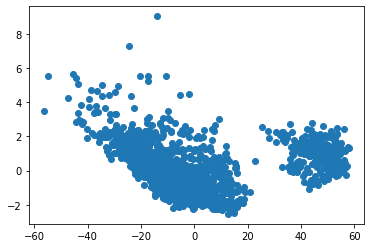

In [123]:
mean_vectors_latent = get_mean_vec_from_control(latent_vectors, pert_cell_vector_dict, cnt_condition = "DMSO")

In [124]:
latent_cos_sims = get_group_cos_sims(mean_vectors_latent, meta_data, grp_id = 'pert_iname', ind_id = 'cell_id')

<ipython-input-4-a97f51e95e6b>:3: RuntimeWarning: invalid value encountered in float_scalars
  return dot(a, b)/(norm(a)*norm(b))


(array([  20.,   25.,   26., 1448., 2203.,  807.,  344.,  320.,  363.,
        9536.]),
 array([-0.97338253, -0.77604428, -0.57870603, -0.38136777, -0.18402952,
         0.01330873,  0.21064699,  0.40798524,  0.60532349,  0.80266175,
         1.        ]),
 <BarContainer object of 10 artists>)

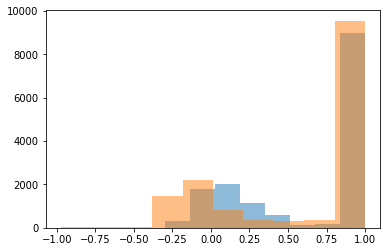

In [125]:
plt.hist(native_cos_sims.values(), alpha = 0.5)
plt.hist(latent_cos_sims.values(), alpha = 0.5)

In [128]:
len(list(lincs_vectors.values()))

500000

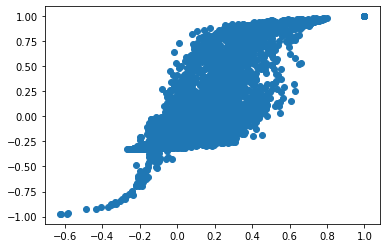

In [129]:
plt.scatter(native_cos_sims.values(), latent_cos_sims.values())

In [117]:
len(set(meta_data.pert_iname))

15208